In [1]:
import os
import re
import glob
import json
import subprocess
import soundfile as sf
import argparse

import pandas as pd
import numpy as np
import librosa
import scipy.io.wavfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split

import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

main_dir = r"Datasets\TIMIT-dataset\data"

# Preprocessing

In [2]:
# wav_paths = [path for path in glob.glob(main_dir + "/*/*/*.wav") 
#     if not (path.endswith("_1.wav") or path.endswith("_2.wav"))]
# frames = [len(librosa.load(wav_path, sr=16000)[0]) for wav_path in wav_paths]
# print("Max frames:", np.max(frames))

# plt.figure(figsize=(10,4))
# sns.histplot(data=frames)
# plt.axvline(x=np.mean(frames), color='red')
# plt.xlabel("Number of frames per sample")
# plt.show()

## Split

In [3]:
# cutoff_limit = 67200
# outlier, split_files, frames = [], [], []
# for wav_path in tqdm(wav_paths, desc='Split'):
#     y = librosa.load(wav_path, sr=16000)[0]
#     n_frames = len(y)
#     frames.append(n_frames)
#     if n_frames >= cutoff_limit:
#         phn_path = wav_path.replace("wav", "phn")
#         lines = open(phn_path, "r").readlines()
#         end = np.array([int(line.split()[1]) for line in lines])
#         try: 
#             idx = np.where(end < n_frames//2)[0][-1]
#             lines_1 = lines[:idx]
#             lines_2 = lines[idx:]
#             factor = int(lines_2[0].split()[0])
#             for i, line in enumerate(lines_2):
#                 start, end, phoneme = line.split()
#                 start = int(start) - factor
#                 end = int(end) - factor
#                 line = " ".join([str(start), str(end), phoneme + "\n"])
#                 lines_2[i] = line
#             f1_path = os.path.splitext(phn_path)[0] + "_1.phn"
#             f2_path = os.path.splitext(phn_path)[0] + "_2.phn"
#             for path, lines in zip([f1_path, f2_path], [lines_1, lines_2]):
#                 with open(path, "w") as f:
#                     f.writelines(lines)    
#             sf.write(f1_path.replace("phn", "wav"), y[:factor], 16000)
#             sf.write(f2_path.replace("phn", "wav"), y[factor:], 16000)
#             split_files.append(wav_path)
#         except:
#             outlier.append(wav_path)
#             pass

# print("Outliers:\n", outlier)

In [4]:
# wav_paths = glob.glob(main_dir + "/*/*/*.wav")
# wav_paths = [path for path in wav_paths if not path in (split_files + outlier)]
# frames = []
# for wav_path in wav_paths:
#     y = librosa.load(wav_path, sr=16000)[0]
#     n_frames = len(y)
#     frames.append(n_frames)

# pd.DataFrame({'wav_paths': wav_paths}).to_csv("Datasets\TIMIT-dataset\data.csv", index=False)

# print("Number of files:", len(wav_paths))
# print("Max frames:", np.max(frames))
# plt.figure(figsize=(10,4))
# sns.histplot(data=frames)
# plt.axvline(x=np.mean(frames), color='red')
# plt.xlabel("Number of frames per sample")
# plt.show()

## Padding

In [5]:
# wav_paths = glob.glob(main_dir + "/*/*/*.wav")
# wav_paths = [path for path in wav_paths 
#     if not path in (split_files + outlier)]
    
# for wav_path in tqdm(wav_paths, desc='Padding'):
#     y = librosa.load(wav_path, sr=16000)[0]
#     n_frames = len(y)
#     y_sil = np.array([])
#     if n_frames != cutoff_limit:
#         pad_length = cutoff_limit - n_frames

#         with open(wav_path.replace("wav", "phn"), "r") as f:
#             lines = f.readlines()
#         phonemes = np.array([line.split()[-1] for line in lines])
#         for i in np.where(phonemes == "h#")[0]:
#             start_sil, end_sil = list(map(int, lines[i].split()[:-1]))
#             y_sil = np.concatenate([y_sil, y[start_sil:end_sil]])
        
#         if len(y_sil) >= pad_length:
#             y_sil = y_sil[:pad_length]
#         else:
#             extension = pad_length - len(y_sil)
#             y_sil = np.pad(y_sil, (0, extension), mode='wrap')
        
#         np.random.shuffle(y_sil)
#         y = np.concatenate([y, y_sil])
        
#         start, end, phoneme = lines.pop(-1).split()
#         if lines[-1].split()[-1] == "h#":
#             line = " ".join([end, str(cutoff_limit), phoneme])
#         else:
#             line = " ".join([start, str(cutoff_limit), "h#\n"])
#         lines.append(line)

#         with open(wav_path.replace("wav", "phn"), "w") as f:
#             f.writelines(lines)

#         sf.write(wav_path, y, 16000)

#     else:
#         pass

In [6]:
d = pd.read_csv("Datasets\TIMIT-dataset\data.csv")
d

,wav_paths
0,Datasets\TIMIT-dataset\data\DR1\FAKS0\SA1.wav
1,Datasets\TIMIT-dataset\data\DR1\FAKS0\SA2.wav
2,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI1573_1...
3,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI1573_2...
4,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI2203.wav
...,...
6984,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX172.wav
6985,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX262.wav
6986,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX352.wav
6987,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX442.wav


# TFrecords

## Write

In [7]:
def ArgParser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--n_splits", dest="n_splits", type=int, default=5)
    parser.add_argument("--sample_rate", dest="sample_rate", type=int, default=16000)
    parser.add_argument("--n_fft", dest="n_fft", type=int, default=2048)
    parser.add_argument("--window_size", dest="window_size", type=int, default=480)
    parser.add_argument("--hop_length", dest="hop_length", type=int, default=160) # 160 samples = 10ms
    parser.add_argument("--n_mels", dest="n_mels", type=int, default=64)
    parser.add_argument("--max_samples", dest="max_samples", type=int, default=67200)
    parser.add_argument("--main_dir", dest='main_dir', type=str, default="Datasets/TIMIT-dataset/tfrec_data")

    
    args = parser.parse_known_args()[0]
    seq_len = int(np.ceil(args.max_samples / args.hop_length))
    parser.add_argument("--seq_len", type=int, default=seq_len)
    return parser.parse_known_args()[0]

args = ArgParser()
args

Namespace(hop_length=160, main_dir='Datasets/TIMIT-dataset/tfrec_data', max_samples=67200, n_fft=2048, n_mels=64, n_splits=5, sample_rate=16000, seq_len=420, window_size=480)

In [8]:
class TFRWriter():
    def __init__(self, args):
        self.samples = d['wav_paths'].tolist()
        self.args = args
        self.dict_path = "Datasets\TIMIT-dataset\phoneme_dict.json"
        self.phoneme_dict = self.get_dict()

    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _int64_feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def serialize_example(self, *args):
        feature = {
            'audio': self._bytes_feature(args[0]),
            'binary_labels': self._bytes_feature(args[1]),
            'framewise_labels': self._bytes_feature(args[2]),
            'attention_mask': self._bytes_feature(args[3]),
            'filename': self._bytes_feature(args[4])}

        example_proto = tf.train.Example(
            features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    def get_binary_labels(self, p_frames): # TODO
        p_frames = tf.convert_to_tensor(p_frames)
        labels = tf.tensor_scatter_nd_update(
            tensor=tf.zeros([p_frames[-1]+1], dtype=tf.int32), 
            indices=tf.expand_dims(p_frames, axis=1), 
            updates=tf.ones([p_frames.shape[0]], dtype=tf.int32))
        padding = tf.zeros([self.args.seq_len-len(labels)], dtype=tf.int32)
        return tf.concat([labels, padding], axis=0)

    def get_framewise_labels(self, p_frames, phonemes): # TODO
        labels = []
        for i in range(1, len(p_frames)):
            for j in range(p_frames[i-1], p_frames[i]):
                labels.append(phonemes[i-1])
        labels = tf.convert_to_tensor(labels)
        padding = tf.zeros([self.args.seq_len-len(labels)], dtype=tf.int32)
        return tf.concat([labels, padding], axis=0)

    def get_attention_mask(self, p_frames):
        return tf.convert_to_tensor(
            [True if i < p_frames[-1] else False for i in range(self.args.seq_len)])

    def get_shards(self):
        speaker_id = [sample.split('\\')[4] for sample in self.samples]
        skf = StratifiedKFold(
            n_splits=self.args.n_splits, shuffle=True, random_state=42)
        return [
            list(map(lambda x: self.samples[x], j)) 
            for i, j in skf.split(self.samples, speaker_id)]

    def get_dict(self):
        phonemes = set()
        markers = ['h#', 'pau', 'epi']
        for sample in self.samples:
            base_path = os.path.splitext(sample)[0]
            with open(base_path + '.phn', "r") as f:
                for line in f.readlines():
                    phoneme = line.split()[-1]
                    if not phoneme in markers:
                        phonemes.add(phoneme)
        phonemes = markers + sorted(Counter(phonemes), key=Counter(phonemes).get, reverse=True)
        phonemes_dict = {v: i+1 for i, v in enumerate(phonemes)}
        with open(self.dict_path, "w") as f:
            json.dump(phonemes_dict, f, sort_keys=False, indent=4)
        return phonemes_dict 
    
    def get_shard_data(self, samples, shard):
        for sample in tqdm(
                samples, total=len(samples), desc=f"Writing shard {shard}"):
            base_path = os.path.splitext(sample)[0]
            p_frames, phonemes = [0], []
            with open(base_path + ".phn") as f:
                for line in f.readlines():
                    p_frame, phoneme = line.split()[1::]
                    p_frames.append(int(p_frame) // self.args.hop_length)
                    phonemes.append(str(phoneme))
            phonemes = list(map(self.phoneme_dict.get, phonemes))
            binary_labels = self.get_binary_labels(p_frames)
            framewise_labels = self.get_framewise_labels(p_frames, phonemes)
            waveform = tf.io.read_file(base_path + ".wav")
            attention_mask = self.get_attention_mask(p_frames)
            filename = str.encode("/".join(sample.split('\\')[-3::]))
            yield {
                "audio": waveform,
                "binary_labels": tf.io.serialize_tensor(binary_labels),
                "framewise_labels": tf.io.serialize_tensor(framewise_labels),
                "attention_mask": tf.io.serialize_tensor(attention_mask),
                "filename": filename}

    def write(self):
        for shard, samples in enumerate(self.get_shards()):
            with tf.io.TFRecordWriter(
                    f"Datasets/TIMIT-dataset/tfrec_data/train_{shard+1}.tfrec") as f:
                for sample in self.get_shard_data(samples, shard+1):
                    example = self.serialize_example(
                        sample['audio'], sample['binary_labels'], 
                        sample['framewise_labels'], sample['attention_mask'],
                        sample['filename'])
                    f.write(example)

# TFRWriter(args).write()

## Loading

In [9]:
class TIMITDataset():
    def __init__(self, args):
        self.files = [os.path.join(args.main_dir, f) for f in os.listdir(args.main_dir)]
        self.args = args
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.BUFFER_SIZE = 512
        self.BATCH_SIZE = 16
        self.train_files, self.val_files = train_test_split(
            self.files, test_size=0.2, shuffle=True)

    def decode_audio(self, string):
        audio = tf.audio.decode_wav(string, desired_samples=self.args.max_samples)[0]
        return tf.squeeze(audio, axis=-1)

    def read_tfrecord(self, example):
        feature_description = {
            'audio': tf.io.FixedLenFeature([], tf.string),
            'binary_labels': tf.io.FixedLenFeature([], tf.string),
            'attention_mask': tf.io.FixedLenFeature([], tf.string)}
        
        example = tf.io.parse_single_example(example, feature_description)
        example['audio'] = self.decode_audio(example['audio'])
        example['binary_labels'] = tf.io.parse_tensor(
            example['binary_labels'], out_type=tf.int32)
        example['attention_mask'] = tf.io.parse_tensor(
            example['attention_mask'], out_type=tf.bool)
        example['binary_labels'] = tf.cast(example['binary_labels'], dtype=tf.float32)
        return example

    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=self.AUTOTUNE)
        return dataset
 
    def SpecAugment(self, sample, training):
        waveform = sample['audio'] / 32678
        if training == True:
            waveform = tfio.audio.fade(
                waveform, fade_in=1000, fade_out=2000, mode="logarithmic")
        spectrogram = tf.abs(tfio.audio.spectrogram(
            waveform, nfft=self.args.n_fft, window=self.args.window_size, 
            stride=self.args.hop_length))
        mel_spectrogram = tfio.audio.melscale(
            spectrogram, rate=self.args.sample_rate, mels=self.args.n_mels, 
            fmin=0, fmax=8000)
        mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
        if training == True:
            mel_spectrogram = tfio.audio.freq_mask(mel_spectrogram, param=10)
            mel_spectrogram = tfio.audio.time_mask(mel_spectrogram, param=10)
        inputs = {"spectrogram": mel_spectrogram, "mask": sample['attention_mask']}
        return (inputs, sample['binary_labels'])

    def train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.map(
            partial(self.SpecAugment, training=True), num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.repeat()
        dataset = dataset.shuffle(self.BUFFER_SIZE)
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

    def val(self):
        dataset = self.load_dataset(self.val_files)
        dataset = dataset.map(
            partial(self.SpecAugment, training=False), num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

train = TIMITDataset(args).train()
val = TIMITDataset(args).val()
train

<PrefetchDataset shapes: ({spectrogram: (None, 420, 64), mask: <unknown>}, <unknown>), types: ({spectrogram: tf.float32, mask: tf.bool}, tf.float32)>

In [10]:
next(iter(train))[1]

<tf.Tensor: shape=(16, 420), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

## SpecAugment

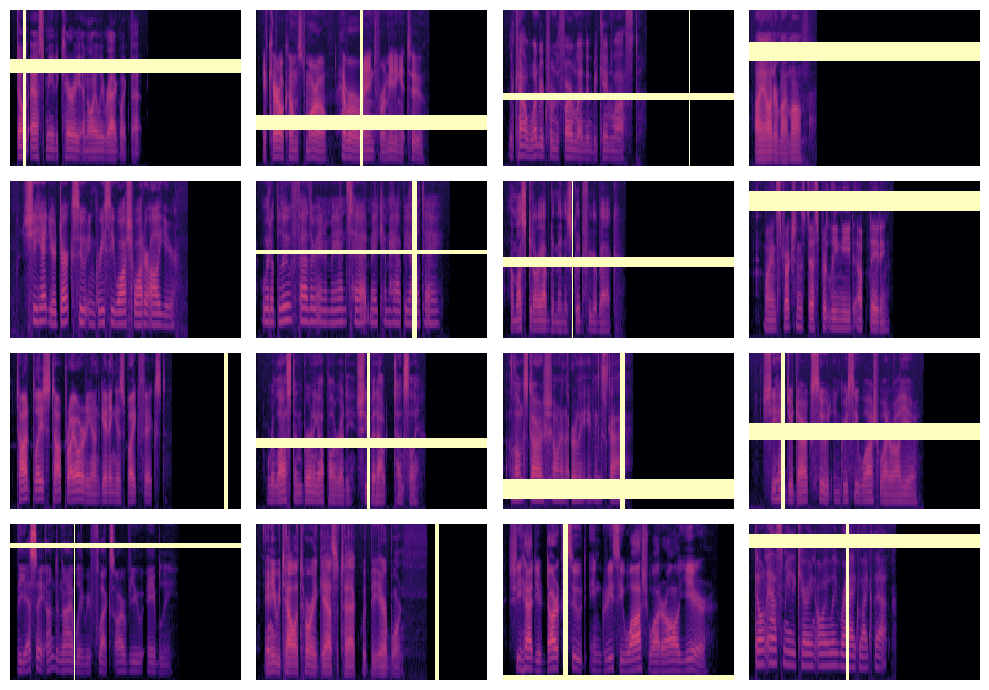

In [11]:
import librosa.display

spectrogram, mask = next(iter(train))[0].values()

plt.figure(figsize=(10, 7))
n_samples = spectrogram.shape[0]
row = 4; col = int(n_samples / 4)

for i in range(n_samples):
    plt.subplot(row, col, i+1)
    plt.axis("off")
    librosa.display.specshow(spectrogram[i].numpy().T)

plt.tight_layout()
plt.show()

In [125]:
def Segmentor(input_shape=(420, 64), dropout=0.0):
    spectrogram = Input(shape=input_shape, dtype=tf.float32, name='spectrogram')
    mask = Input(shape=input_shape[0], dtype=tf.bool, name='mask')

    layer_1 = Bidirectional(LSTM(200, dropout=dropout, return_sequences=True), name="layer_1")
    layer_2 = Bidirectional(LSTM(100, dropout=dropout, return_sequences=True), name="layer_2")
    layer_3 = Dense(1, activation='sigmoid', name='layer_3')

    x = layer_1(inputs=spectrogram, mask=mask)
    x = layer_2(x)
    x = layer_3(x)
    outputs = tf.squeeze(x, axis=-1)
    return Model(inputs=[spectrogram, mask], outputs=outputs, name='Segmentor')

model = Segmentor()
model.summary()

Model: "Segmentor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spectrogram (InputLayer)        [(None, 420, 64)]    0                                            
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 420)]        0                                            
__________________________________________________________________________________________________
layer_1 (Bidirectional)         (None, 420, 400)     424000      spectrogram[0][0]                
                                                                 mask[0][0]                       
__________________________________________________________________________________________________
layer_2 (Bidirectional)         (None, 420, 200)     400800      layer_1[0][0]            

In [126]:
y_pred = model.predict(val)[0]
y_true = next(iter(val))[1][0]
metrics(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.2720199>

In [127]:
y_pred

array([0.56485   , 0.5375855 , 0.513972  , 0.5008103 , 0.49227408,
       0.48835814, 0.48042738, 0.4742114 , 0.46714464, 0.46301442,
       0.46158096, 0.45886382, 0.46213958, 0.47021136, 0.4710872 ,
       0.4719756 , 0.47372174, 0.47013456, 0.47726104, 0.47844833,
       0.47948492, 0.48114625, 0.48593566, 0.4890022 , 0.48531199,
       0.48855537, 0.48937386, 0.49113464, 0.49198   , 0.49380842,
       0.49595612, 0.49841562, 0.4984919 , 0.50402546, 0.50267214,
       0.50037676, 0.49962133, 0.50453687, 0.5060208 , 0.5051006 ,
       0.50627804, 0.5094239 , 0.51746476, 0.52398145, 0.522477  ,
       0.5219564 , 0.52003217, 0.51979136, 0.50972354, 0.50819826,
       0.50507635, 0.49813455, 0.4890728 , 0.47085714, 0.47038504,
       0.46471143, 0.45858583, 0.45606694, 0.43810773, 0.43776488,
       0.4459956 , 0.4542332 , 0.463394  , 0.4762981 , 0.49069604,
       0.4858966 , 0.47981536, 0.490743  , 0.4869231 , 0.4854859 ,
       0.48508376, 0.48645088, 0.5050104 , 0.50728345, 0.50787

In [118]:
epochs = 2
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
jaccard = tf.keras.metrics.MeanIoU(num_classes=2, axis=-1, name='jaccard')

for epoch in range(epochs):
    for step, (X_train, y_train) in enumerate(train):
        sample_weights = tf.cast(X_train['mask'][0], tf.int32)
        with tf.GradientTape() as tape:
            logits = model(X_train, training=True)
            loss_value = loss_fn(y_train, logits)
        print(logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        metric.update_state()

    train_acc = metric.result()

tf.Tensor(
[[0.52202654 0.49155498 0.47586948 ... 0.49991864 0.49991864 0.49991864]
 [0.45455426 0.43092152 0.42132086 ... 0.49991864 0.49991864 0.49991864]
 [0.35997796 0.336247   0.32044318 ... 0.49991864 0.49991864 0.49991864]
 ...
 [0.4405235  0.40360308 0.38678297 ... 0.49991864 0.49991864 0.49991864]
 [0.47307605 0.43737411 0.4199499  ... 0.49991864 0.49991864 0.49991864]
 [0.38789156 0.370268   0.35957596 ... 0.49991864 0.49991864 0.49991864]], shape=(16, 420), dtype=float32)
tf.Tensor(
[[0.48092657 0.4565684  0.43911478 ... 0.49991834 0.49991834 0.49991834]
 [0.45276916 0.4318916  0.42186347 ... 0.49991834 0.49991834 0.49991834]
 [0.40324798 0.36887565 0.33955953 ... 0.49991834 0.49991834 0.49991834]
 ...
 [0.33719853 0.30933222 0.29552066 ... 0.49991834 0.49991834 0.49991834]
 [0.4665474  0.4418921  0.42688832 ... 0.49991834 0.49991834 0.49991834]
 [0.47424582 0.4726186  0.4660198  ... 0.49991834 0.49991834 0.49991834]], shape=(16, 420), dtype=float32)
tf.Tensor(
[[0.47803396 

KeyboardInterrupt: 